In [289]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

In [290]:
# Random seed
np.random.seed(42)
torch.manual_seed(42)

In [291]:
# Load data
df = pd.read_csv('../data/BMED_data_v6.csv')

In [292]:
# Feedforward network for migration prediction
class MigrationPredictor(nn.Module):
    def __init__(self, hidden_nodes = 64, hidden_layers = 3):
        super().__init__()
        
        n_features = 6
        n_outputs = 3

        # Layer configuration
        layers = []
        # input layer
        layers.append(nn.Linear(n_features, hidden_nodes))
        layers.append(nn.ReLU())

        # hidden layers
        for _ in range(hidden_layers - 1):
            layers.append(nn.Linear(hidden_nodes, hidden_nodes))
            layers.append(nn.ReLU())

        # output layer
        layers.append(nn.Linear(hidden_nodes, n_outputs))

        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

In [293]:
# Physical Layers for State update
class PhysicalLayer:
    def __init__(self, dt = 0.1):
        self.dt = dt
    
    def update_state(self, cur_states, migrations):
        # Current States
        T = cur_states[0]
        V = cur_states[1]
        E = cur_states[2]
        Ki = cur_states[3]
        CF_LA = cur_states[4]
        CA_LA = cur_states[5]
        VF = cur_states[6]
        VA = cur_states[7]
        
        # Migration
        dNLA = migrations[0] * self.dt
        dVF = migrations[1] * self.dt
        dVA = migrations[2] * self.dt

        # Fixed variables
        nT = T
        nV = V
        nE = E
        nKi = Ki       
        
        # New Volumes
        nVF = VF + dVF
        nVA = VA + dVA

        # New Concentrations
        nCF_LA = (CF_LA * VF - dNLA) / nVF
        nCA_LA = (CA_LA * VA + dNLA) / nVA

        # New States
        new_states = cur_states.clone()
        new_states[0] = nT
        new_states[1] = nV
        new_states[2] = nE
        new_states[3] = nKi
        new_states[4] = nCF_LA
        new_states[5] = nCA_LA
        new_states[6] = nVF
        new_states[7] = nVA
        
        return new_states

In [294]:
class BMEDDataset(Dataset):
    def __init__(self, dict_spline):
        self.states = ['T', 'V', 'E', 'Ki', 'CF_LA', 'CA_LA', 'VF', 'VA']
        self.experiments = []

        for exp_id, exp_data in dict_spline.items():
            # Save whole data of each experiment in one sample
            exp_array = exp_data[self.states].values
            times = exp_data['t'].values
            self.experiments.append({
                'init_state': torch.tensor(exp_array[0], dtype = torch.float32), # initial state
                'measured_state': torch.tensor(exp_array, dtype = torch.float32), # whole measurements
                'times': torch.tensor(times, dtype = torch.float32) # time points
            })
    
    def __len__(self):
        return len(self.experiments)
    
    def __getitem__(self, idx):
        return self.experiments[idx]

In [295]:
class BMEDModel(nn.Module):
    def __init__(self, hidden_nodes = 32, hidden_layers = 3, dt = 0.1, scaler = None):
        super().__init__()
        self.migration_predictor = MigrationPredictor(hidden_nodes, hidden_layers)
        self.physical_layer = PhysicalLayer(dt)
        self.scaler = scaler
        self.dt = dt

    def forward(self, init_state, times):

        cur_state = init_state # batch size 1
        cur_time = 0.0
        pred_states = []
        measured_indices = []

        times = times
        times_np = times[0].numpy()
        max_time = times_np[-1]
        measured_indices.append(0)

        # 초기 상태 저장
        pred_states.append(cur_state)

        while cur_time < max_time:
            # input_feature에 해당하는 변수만 정규화
            input_state = cur_state[:, :6]  # input feature 추출, 2차원 유지지
            
            norm_input = self.scaler.transform(input_state.detach().numpy())
            norm_input = torch.tensor(norm_input)
            
            # 상태 예측
            migration = self.migration_predictor(norm_input)  # (1, 6) -> (1, 3)
            cur_state = self.physical_layer.update_state(cur_state[0], migration[0]).unsqueeze(0)  # (1,8)
            pred_states.append(cur_state)  # (1, 8)
            cur_time += self.dt

            # 측정 시간과 매칭
            for t in times_np:
                if abs(cur_time - t) < self.dt/2:
                    measured_indices.append(len(pred_states) - 1)

        # 현재 배치의 예측 상태들을 스택
        pred_states = torch.cat(pred_states, dim=0)  # (n_steps, 8)

        return pred_states, measured_indices

In [296]:
def custom_loss(pred_states, measured_indices, measured_states):
    total_loss = 0
    for idx, measured_state in zip(measured_indices, measured_states[0]):
        predicted_state = pred_states[idx]
        total_loss += torch.mean((predicted_state - measured_state) ** 2)

    return total_loss

In [297]:
def train_model(model, train_loader, epochs = 100, learning_rate = 0.001, weight_decay = 1e-5):
    optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate, weight_decay= weight_decay)

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0

        for exp in train_loader:
            optimizer.zero_grad()

            init_state = exp['init_state']
            measured_state = exp['measured_state']
            times = exp['times']

            # Simulation
            pred_state, measured_indices = model(init_state, times)

            # Loss
            loss = custom_loss(pred_state, measured_indices, measured_state)

            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        avg_loss = epoch_loss / len(train_loader)
        if (epoch + 1) % 10 == 0:
            print(f'Epoch {epoch + 1}/{epochs}, Loss: {avg_loss:.8f}')

In [298]:
def prepare_data(df_path, exp_idx = None):
    # Load raw data
    df = pd.read_csv(df_path)

    if exp_idx is not None:
        df = df[df['exp'].isin(exp_idx)]

    # split the data by experiment number
    dict_spline = {}
    for exp in df['exp'].unique():
        dict_spline[exp] = df[df['exp'] == exp].sort_values('t')

    # scaler
    scaler = StandardScaler()
    col_to_scale = ['T', 'V', 'E', 'Ki', 'CF_LA', 'CA_LA']
    scaler.fit(df[col_to_scale].values)
    return dict_spline, scaler

In [299]:
def plot_results(model, dataset, exp_idx=0):
    # 데이터 준비
    exp = dataset.experiments[exp_idx]
    init_state = torch.tensor(exp['init_state'], dtype=torch.float32).unsqueeze(0)
    times = torch.tensor(exp['times'], dtype=torch.float32).unsqueeze(0)
    measured_state = torch.tensor(exp['measured_state'], dtype=torch.float32)
    
    # 예측
    with torch.no_grad():
        pred_states, measured_indices = model(init_state, times)
    
    # 예측을 위한 시간 포인트 생성 (dt = 0.1 간격)
    t_pred = torch.arange(0, times[0][-1].item() + 0.1, 0.1)
    
    # 변수 이름과 단위
    var_names = {
        'T': 'Temperature (°C)',
        'V': 'Voltage (V)',
        'E': 'Electric Field (V/cm)',
        'Ki': 'Ion Strength (M)',
        'CF_LA': 'Feed LA Conc. (M)',
        'CA_LA': 'Acid LA Conc. (M)',
        'VF': 'Feed Volume (L)',
        'VA': 'Acid Volume (L)'
    }
    
    # 그래프 그리기
    fig, axes = plt.subplots(4, 2, figsize=(15, 20))
    axes = axes.ravel()
    
    for i, (var, label) in enumerate(var_names.items()):
        ax = axes[i]
        # 실제 측정값 (점으로 표시)
        ax.plot(times[0].numpy(), measured_state[:, i].numpy(), 
                'bo', label='Measured', markersize=6)
        # 예측값 (연속 선으로 표시)
        ax.plot(t_pred.numpy(), pred_states[:, i].numpy(), 
                'r-', label='Predicted', linewidth=2)
        
        ax.set_title(label, fontsize=12, pad=10)
        ax.set_xlabel('Time (hr)', fontsize=10)
        ax.legend(fontsize=10)
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

In [300]:
# Generate Dataloader
df_path = '../data/BMED_data_v6.csv'
exp_idx = [1,2]
dict_spline, scaler = prepare_data(df_path)

dataset = BMEDDataset(dict_spline)
train_loader = DataLoader(dataset, batch_size = 1, shuffle = True)

In [ ]:
# Generate Model
hidden_nodes = 128
hidden_layers = 5
dt = 0.1
epochs = 10000
lr = 0.0001
wd = 1e-5
model = BMEDModel(hidden_nodes=hidden_nodes, hidden_layers=hidden_layers, dt = dt, scaler=scaler)
train_model(model=model, train_loader=train_loader, epochs = epochs, learning_rate=lr, weight_decay = wd)

Epoch 10/10000, Loss: 0.09004537
Epoch 20/10000, Loss: 0.07763939
Epoch 30/10000, Loss: 0.06806603
Epoch 40/10000, Loss: 0.07550763
Epoch 50/10000, Loss: 0.06122631
Epoch 60/10000, Loss: 0.05807584
Epoch 70/10000, Loss: 0.05303438
Epoch 80/10000, Loss: 0.05382883
Epoch 90/10000, Loss: 0.05509288
Epoch 100/10000, Loss: 0.05799912
Epoch 110/10000, Loss: 0.05156206
Epoch 120/10000, Loss: 0.05047186
Epoch 130/10000, Loss: 0.04731602
Epoch 140/10000, Loss: 0.06300817
Epoch 150/10000, Loss: 0.04766067
Epoch 160/10000, Loss: 0.04619086
Epoch 170/10000, Loss: 0.04592565
Epoch 180/10000, Loss: 0.04551743
Epoch 190/10000, Loss: 0.04967101
Epoch 200/10000, Loss: 0.05065693
Epoch 210/10000, Loss: 0.05647711
Epoch 220/10000, Loss: 0.05834646
Epoch 230/10000, Loss: 0.04769201
Epoch 240/10000, Loss: 0.04495719
Epoch 250/10000, Loss: 0.04613761
Epoch 260/10000, Loss: 0.06199007
Epoch 270/10000, Loss: 0.04438282
Epoch 280/10000, Loss: 0.04531571
Epoch 290/10000, Loss: 0.04428530
Epoch 300/10000, Loss: 

C:\Users\bsjun\AppData\Local\Temp\ipykernel_25332\3702422347.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  init_state = torch.tensor(exp['init_state'], dtype=torch.float32).unsqueeze(0)
C:\Users\bsjun\AppData\Local\Temp\ipykernel_25332\3702422347.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  times = torch.tensor(exp['times'], dtype=torch.float32).unsqueeze(0)
C:\Users\bsjun\AppData\Local\Temp\ipykernel_25332\3702422347.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  measured_state = torch.tensor(exp['measured_state'], dtyp

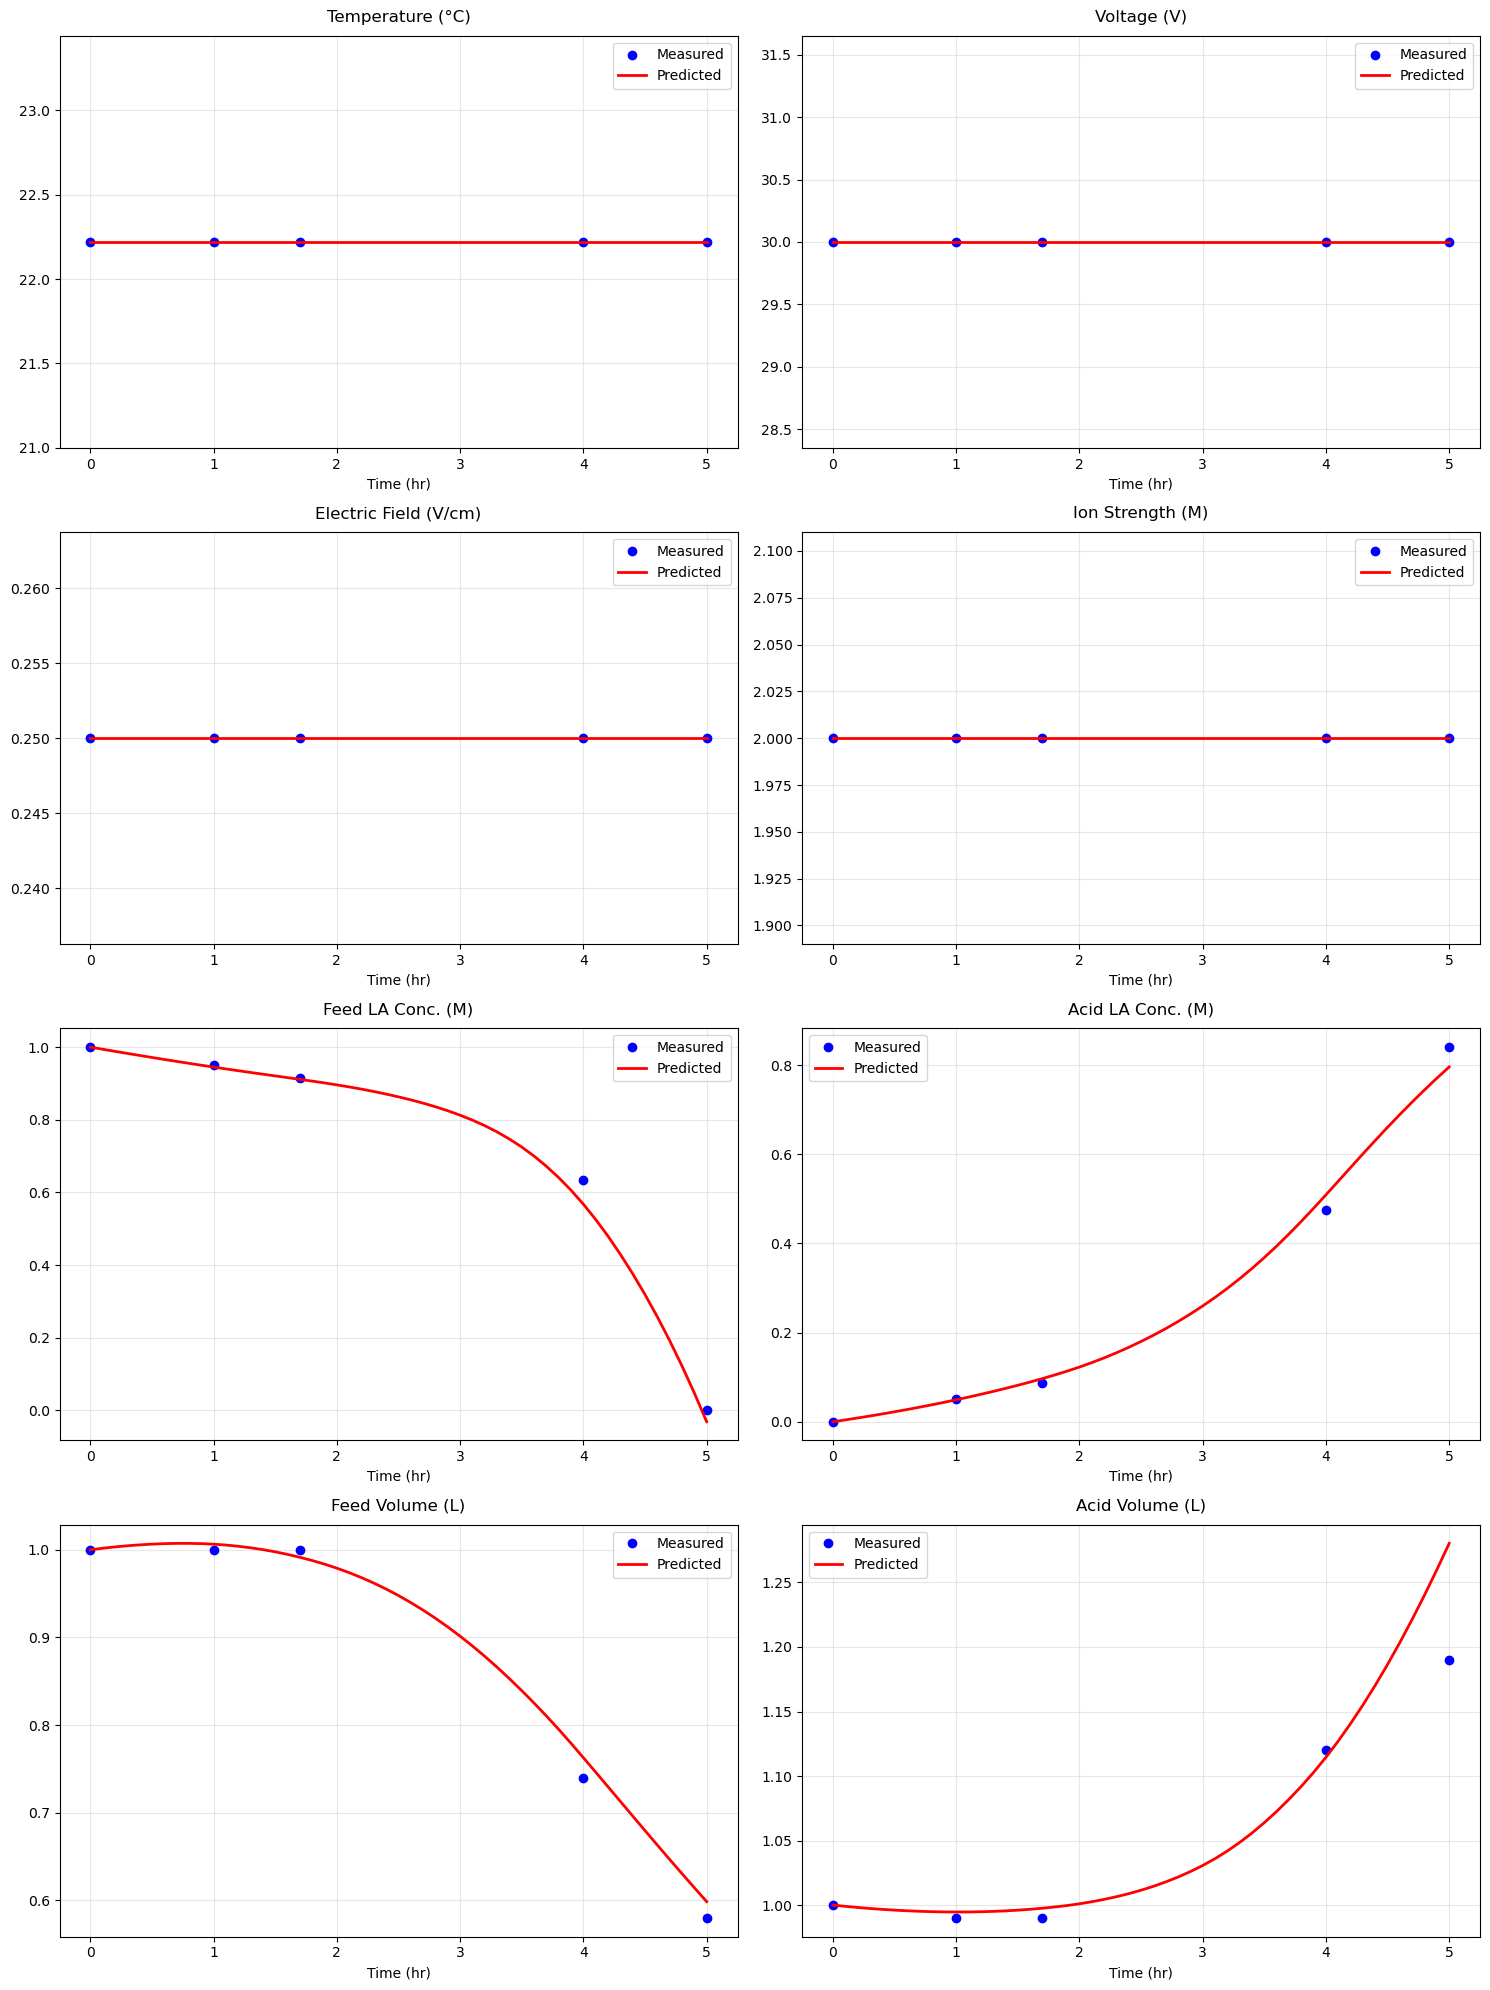

In [ ]:
# 사용 예시:
plot_results(model, dataset, exp_idx=2)  # exp_idx로 실험 선택